In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Analysis

# MORE By County Analysis

In [3]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Sales.ProductID, Sales.VendorID, Store.County, Store.lat, Store.lng, County.Year, County.Population, County.UNEMPLOYMENT_RATE, Sales.VolumeSold_Liters, Sales.Sale_Dollars
              FROM ((Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              INNER JOIN County ON County.County=Store.County)
              WHERE Sales.Date BETWEEN '2021-01-01' AND '2021-12-31' 
              AND County.Year = '2021';'''
cursor.execute(query)
result1 = cursor.fetchall()
cursor.close()
dbconn.close()

In [71]:
# Put the database in a data frame format.
temp1 = pd.DataFrame(result1, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'ProductID',
                                            'VendorID',
                                            'County',
                                            'lat',
                                            'lng',
                                            'Year',
                                            'Population',
                                            'Unemployment_Rate',
                                            'VolumeSold_Liters',
                                            'Sale_Dollars'])

In [72]:
temp1.head()

,TransactionID,Date,StoreID,ProductID,VendorID,County,lat,lng,Year,Population,Unemployment_Rate,VolumeSold_Liters,Sale_Dollars
0,INV-41517100002,2021-11-01,5417,36308,434,linn,41.88875,-91.67497,2021,230479,4.9,10.50,64.56
1,INV-41518800037,2021-11-01,4921,19061,65,linn,41.96451,-91.73978,2021,230479,4.9,0.05,10.50
2,INV-41518900014,2021-11-01,5687,11296,260,linn,41.96442,-91.72973,2021,230479,4.9,9.00,298.68
3,INV-41521200068,2021-11-01,2648,86250,434,polk,41.56108,-93.77478,2021,504735,4.2,9.00,48.12
4,INV-41523800012,2021-11-01,4379,52596,205,polk,41.58511,-93.78953,2021,504735,4.2,3.75,48.75


## Stores Locations Mini Table

In [73]:
map_stores0 = temp1.drop_duplicates(subset='StoreID', keep='first')
map_stores = map_stores0[['StoreID','County','lat','lng']]


In [74]:
map_stores.head()

,StoreID,County,lat,lng
0,5417,linn,41.88875,-91.67497
1,4921,linn,41.96451,-91.73978
2,5687,linn,41.96442,-91.72973
3,2648,polk,41.56108,-93.77478
4,4379,polk,41.58511,-93.78953


In [75]:
# convert the lat and lng coordinates to geometry
import geopandas as gpd
from shapely.geometry import Point, Polygon

map_stores["lat"] = map_stores["lat"].astype('float')
map_stores["lng"] = map_stores["lng"].astype('float')

geometry = [Point(xy) for xy in zip( map_stores["lng"], map_stores["lat"])]
geometry[:3]

crs = "EPSG:4326"

# create new geo-DataFrame
store_geo = gpd.GeoDataFrame(map_stores,crs = crs,
                         geometry = geometry)

/tmp/ipykernel_3238/3030766482.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lat"] = map_stores["lat"].astype('float')
/tmp/ipykernel_3238/3030766482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lng"] = map_stores["lng"].astype('float')


In [76]:
store_geo.head()

,StoreID,County,lat,lng,geometry
0,5417,linn,41.88875,-91.67497,POINT (-91.67497 41.88875)
1,4921,linn,41.96451,-91.73978,POINT (-91.73978 41.96451)
2,5687,linn,41.96442,-91.72973,POINT (-91.72973 41.96442)
3,2648,polk,41.56108,-93.77478,POINT (-93.77478 41.56108)
4,4379,polk,41.58511,-93.78953,POINT (-93.78953 41.58511)


In [77]:
# loading county csv
county = pd.read_csv('../data/county.csv')
county.rename(columns={'UNEMPLOYMENT RATE': 'UNEMPLOYMENT_RATE'}, inplace=True)
county_2021 = county.loc[county['Year']==2021]
county_2021.head()

,County,Year,Population,Income_PerCapita,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE
1089,adair,2021,6888,NaN,4300,4180,120,2.7
1090,adams,2021,3496,NaN,2010,1950,60,2.8
1091,allamakee,2021,13548,NaN,7010,6760,250,3.5
1092,appanoose,2021,12335,NaN,6060,5800,260,4.3
1093,audubon,2021,5338,NaN,3070,2970,90,3.1


In [78]:
# want income data for 2020 (since 2021 is unavailable)
county_2020 = county.loc[county['Year']==2020]
county_2020_income = county_2020[['County','Income_PerCapita']]
county_2020_income.head()

,County,Income_PerCapita
990,adair,56422.0
991,adams,59569.0
992,allamakee,51107.0
993,appanoose,42125.0
994,audubon,54313.0


In [79]:
df_bycounty_temp0 = temp1.groupby(['County']).agg({'Sale_Dollars':'sum',
                               'StoreID':'nunique',
                               'VolumeSold_Liters':'sum'})
df_bycounty_temp0.rename(columns={'Sale_Dollars': 'Annual_SalesDollars',
                            'StoreID': 'StoreCount',
                            'VolumeSold_Liters': 'Annual_VolumeSold'}, inplace=True)

df_bycounty_temp0.head()

,Annual_SalesDollars,StoreCount,Annual_VolumeSold
County,,,
adair,683600.94,8,43177.07
adams,215545.86,2,13532.61
allamakee,1091295.24,10,77669.16
appanoose,1107116.79,9,71170.37
audubon,288076.35,4,19729.46


In [82]:
df_bycounty_temp1 = df_bycounty_temp0.merge(county_2021, on = ['County'], how = 'left')
df_bycounty_temp1['StoresPer10K'] = (df_bycounty_temp1['StoreCount']/df_bycounty_temp1['Population'])*10000
df_bycounty_temp1['SalesPerCapita'] = (df_bycounty_temp1['Annual_SalesDollars']/df_bycounty_temp1['Population'])
df_bycounty_temp1['VolSoldPerCapita'] = (df_bycounty_temp1['Annual_VolumeSold']/df_bycounty_temp1['Population'])
df_bycounty_temp1 = df_bycounty_temp1.drop(columns = ['Income_PerCapita'])
df_bycounty_temp1.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita
0,adair,683600.94,8,43177.07,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448
1,adams,215545.86,2,13532.61,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884
2,allamakee,1091295.24,10,77669.16,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888
3,appanoose,1107116.79,9,71170.37,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791
4,audubon,288076.35,4,19729.46,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040


In [83]:
# Adding 2020 income column
df_bycounty = df_bycounty_temp1.merge(county_2020_income, on = ['County'], how = 'left')
df_bycounty.rename(columns={'Income_PerCapita': 'Income_PerCapita_2020'}, inplace=True)
df_bycounty.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020
0,adair,683600.94,8,43177.07,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448,56422.0
1,adams,215545.86,2,13532.61,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0
2,allamakee,1091295.24,10,77669.16,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888,51107.0
3,appanoose,1107116.79,9,71170.37,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791,42125.0
4,audubon,288076.35,4,19729.46,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040,54313.0


In [84]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0, 0.6)

In [85]:
# County Boundaries Shape File
map_counties = gpd.read_file(
    '../data/County_Boundaries_of_Iowa/geo_export_b0962504-4b8e-4a81-9f03-586d790445ed.shp')

map_counties.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties = map_counties.sort_values(by=['County'])

map_counties['County'] = map_counties['County'].str.lower()
map_counties.loc[map_counties['County']=="obrien",'County']="o'brien"
map_counties.head()

,gnis_featu,fips,state_coun,County,acres,geometry
71,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504..."
80,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158..."
5,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500..."
97,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898..."
58,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863..."


In [86]:
# County Points Shape File
map_counties_pts = gpd.read_file(
    '../data/Primary_Points_for_Iowa_Counties/geo_export_7ec5c31d-2f89-4961-bacf-1dbe5f7b3ed7.shp')

map_counties_pts.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties_pts['County'] = map_counties_pts['County'].str.lower()

In [87]:
# Digging into the discrepancies (county names need to match)
temp2 = list(map_counties['County'].unique())
temp1 = list(df_by_county['County'].unique())
s = set(temp2)
temp3 = [x for x in temp1 if x not in s]
temp3

[]

In [101]:
map_counties2 = map_counties.merge(df_bycounty, on = ['County'], how = 'left')
map_counties2.head()

,gnis_featu,fips,state_coun,County,acres,geometry,Annual_SalesDollars,StoreCount,Annual_VolumeSold,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020
0,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504...",683600.94,8,43177.07,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448,56422.0
1,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158...",215545.86,2,13532.61,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0
2,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500...",1091295.24,10,77669.16,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888,51107.0
3,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898...",1107116.79,9,71170.37,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791,42125.0
4,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863...",288076.35,4,19729.46,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040,54313.0


In [102]:
map_counties2.nlargest(5, 'StoreCount')['County']

76          polk
56          linn
6     black hawk
81         scott
51       johnson
Name: County, dtype: object

In [103]:
map_counties2.nlargest(5, 'Population')['County']

76          polk
56          linn
81         scott
51       johnson
6     black hawk
Name: County, dtype: object

In [104]:
map_counties2.nlargest(5, 'StoresPer10K')['County'].reset_index()

,index,County
0,70,o'brien
1,75,pocahontas
2,59,lyon
3,0,adair
4,73,palo alto


In [105]:
map_counties2.nlargest(5, 'SalesPerCapita')['County'].reset_index()

,index,County
0,29,dickinson
1,16,cerro gordo
2,76,polk
3,6,black hawk
4,81,scott


In [106]:
map_counties2.nlargest(5, 'VolSoldPerCapita')['County'].reset_index()

,index,County
0,29,dickinson
1,16,cerro gordo
2,76,polk
3,6,black hawk
4,13,carroll


In [114]:
map_counties2.nlargest(5, 'Income_PerCapita_2020')['County'].reset_index()

,index,County
0,24,dallas
1,29,dickinson
2,65,mitchell
3,17,cherokee
4,64,mills


In [107]:
#map_counties2.nlargest(99, 'Population')['County'].reset_index()

# Map It Out

No handles with labels found to put in legend.


<AxesSubplot:>

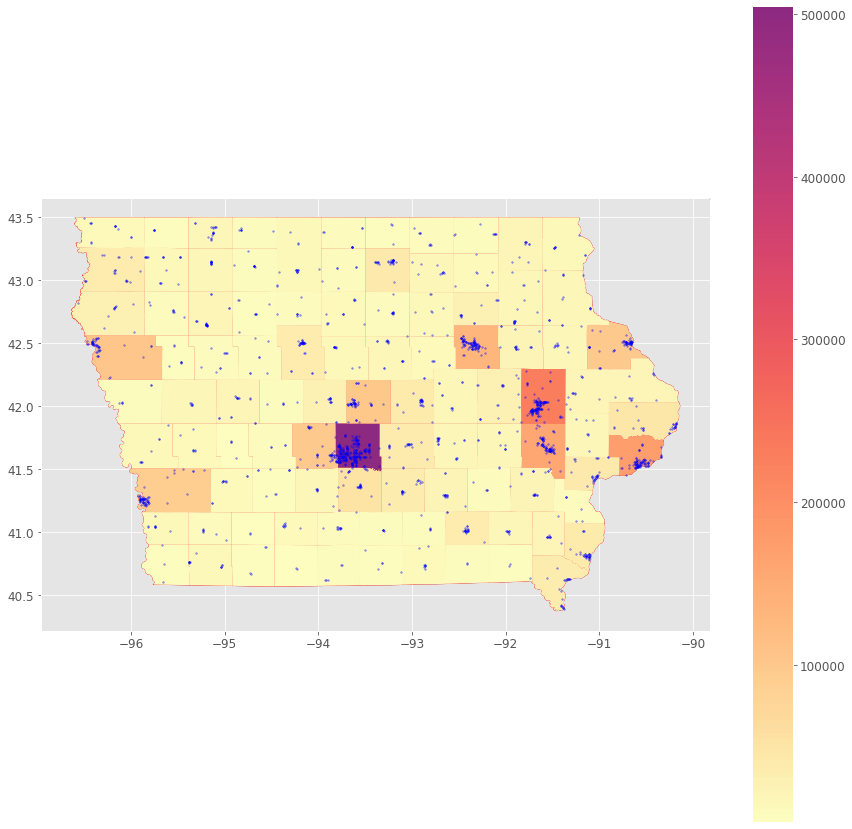

In [108]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

#ax.set_title('Stores in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='Population', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

#for name in map_counties_pts['County']:
#    if name in ['polk','linn','black hawk','scott','johnson']:
#        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
#        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
#        plt.text(x,y,name, fontsize=14, horizontalalignment='center')
        
store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Stores per 10K Residents in 2021'}>

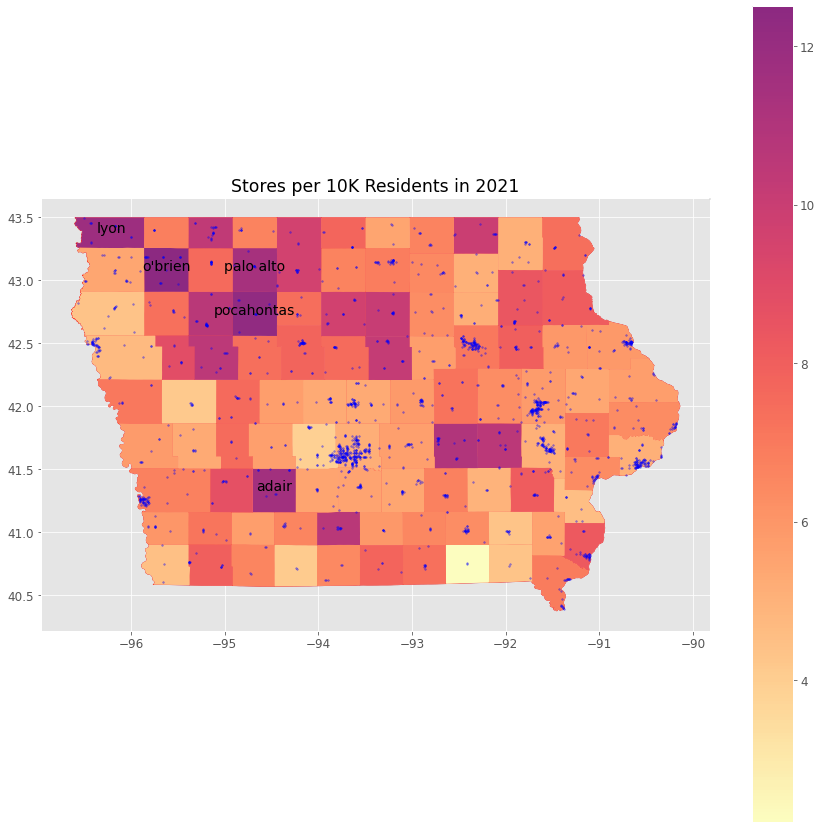

In [109]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Stores per 10K Residents in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='StoresPer10K', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ["o'brien",'pocahontas','lyon','adair','palo alto']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Sales per Capita in 2021'}>

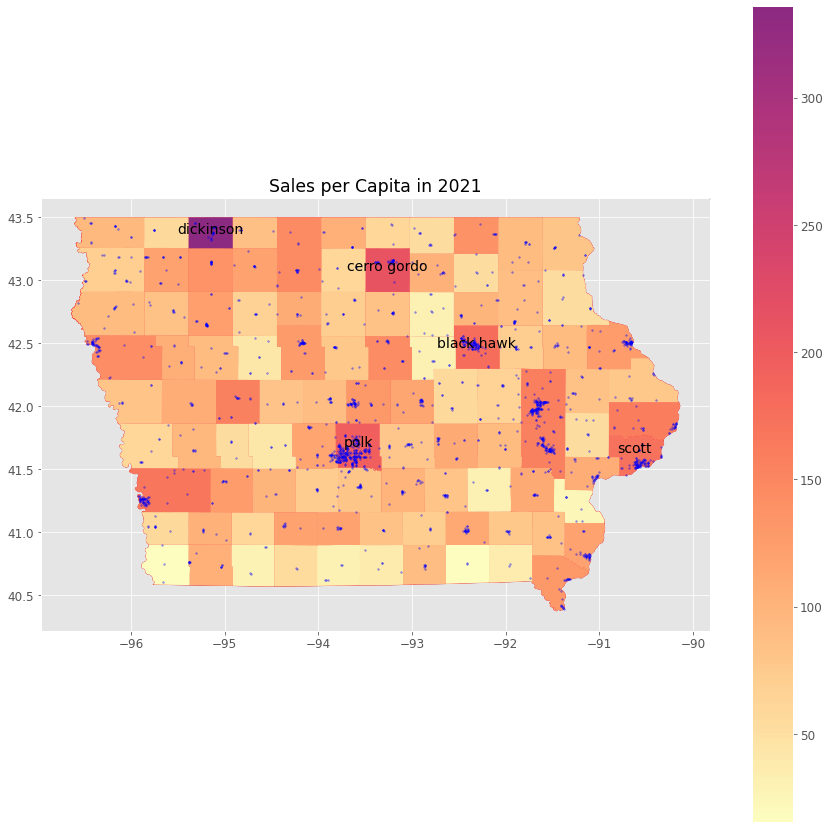

In [110]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Sales per Capita in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='SalesPerCapita', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dickinson','cerro gordo','polk','black hawk','scott']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Volume Sold per Capita in 2021'}>

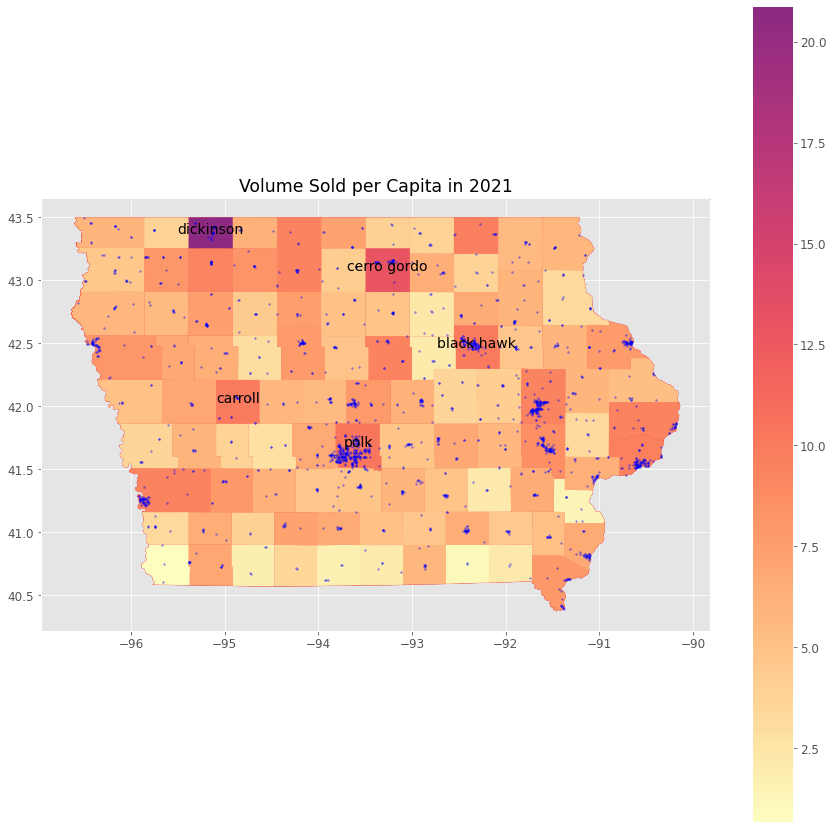

In [111]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Volume Sold per Capita in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='VolSoldPerCapita', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dickinson','cerro gordo','polk','black hawk','carroll']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


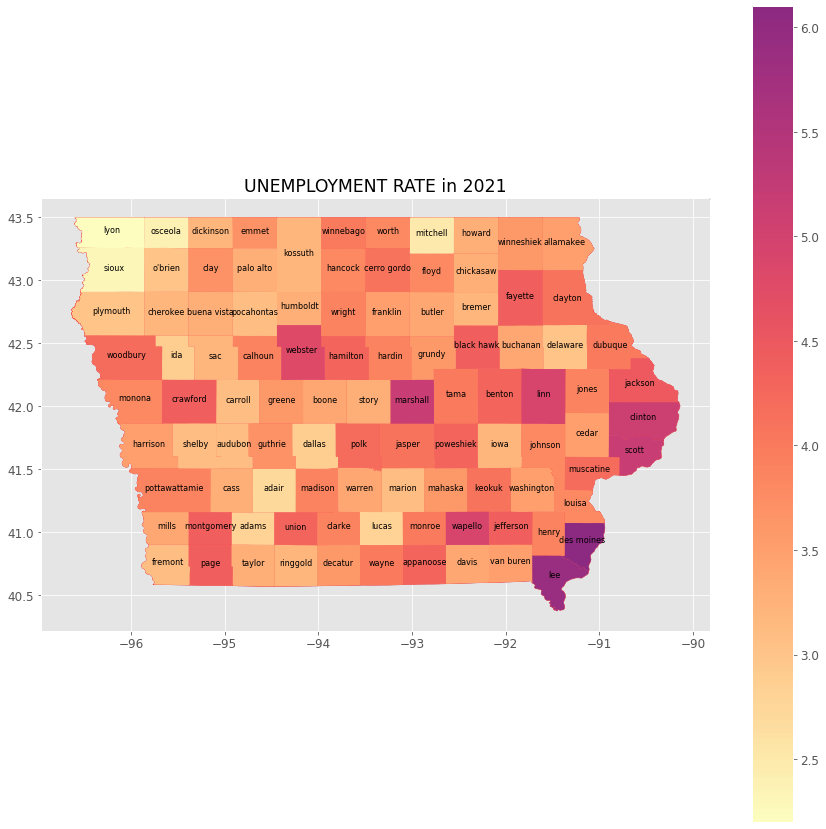

In [112]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('UNEMPLOYMENT RATE in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='UNEMPLOYMENT_RATE', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
    y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
    plt.text(x,y,name, fontsize=8, horizontalalignment='center')

No handles with labels found to put in legend.


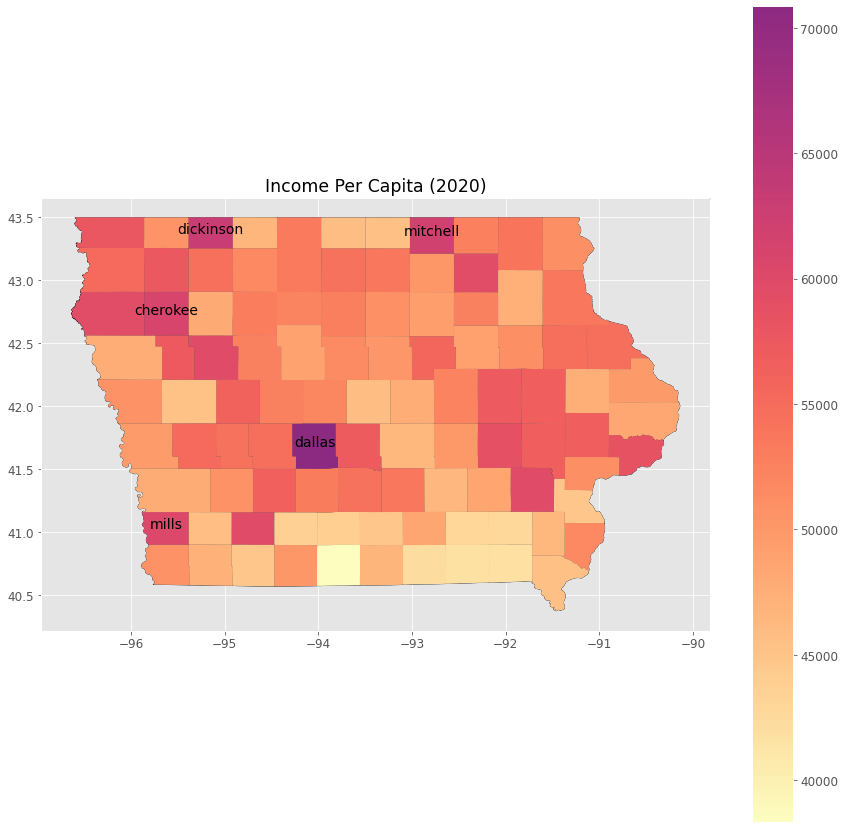

In [117]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Income Per Capita (2020)')

map_counties.plot(color='white', edgecolor='black', ax=ax)
map_counties2.plot(column='Income_PerCapita_2020', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dallas','dickinson','mitchell','cherokee','mills']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

# Store Information???

In [ ]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Store.StoreType, Sales.ProductID, Store.County, Store.lat, Store.lng
              FROM (Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              WHERE Sales.Date BETWEEN '2021-01-01' AND '2021-12-31';'''
cursor.execute(query)
result2 = cursor.fetchall()
cursor.close()
dbconn.close()

In [ ]:
# Put the database in a data frame format.
temp2 = pd.DataFrame(result2, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'StoreType',
                                            'ProductID',
                                            'County',
                                            'lat',
                                            'lng'])

In [ ]:
temp2.head()

In [ ]:
temp2['StoreID'].nunique()

In [ ]:
price = pd.read_csv('../data/product_price.csv')
price.head()